## Self Attention

Various new research in sentence representation are using attention mechanisms to perform efficient lookups and to provide extra source of information to guide the extraction of the meaning of a sentence.

### Drawbacks of Recurrent Networks

- The major motivation for using attention is that Recurrent Neural Networks (RNN's) either composed of LSTM or GRU suffer from long term dependency issues, as by running sequential computations, the longer the sentence is more number of computations are to be performed, which results in numerical overflow / underflow issues in the gradients being passed back, thus the final state of the RNN holds little relevant information about the sentence

- A common approach is to use [Attention](http://www.wildml.com/2016/01/attention-and-memory-in-deep-learning-and-nlp/) over the hidden states of the RNN (Bahdanau et al). Here, in an encoder-decoder structure, the decoder maintains a set of vectors which states how much importance it should provide to a particular hidden state in the encoded sequence. 

- However, the final state of the RNN is still calculated as the max or average pooling from either RNN's hidden states or convolved n-grams (in case of CNN representation).

### Paper: A structured self-attentive sentence embedding, Lin et al 2017

[Arxiv](https://arxiv.org/pdf/1703.03130.pdf)

#### Self attentive sentence embedding

- Replaces the max pooling or averaging step with a self-attention
- Due to direct access to hidden representations from the previous steps, it relieves the long term dependency issue for LSTM

#### Model Architecture

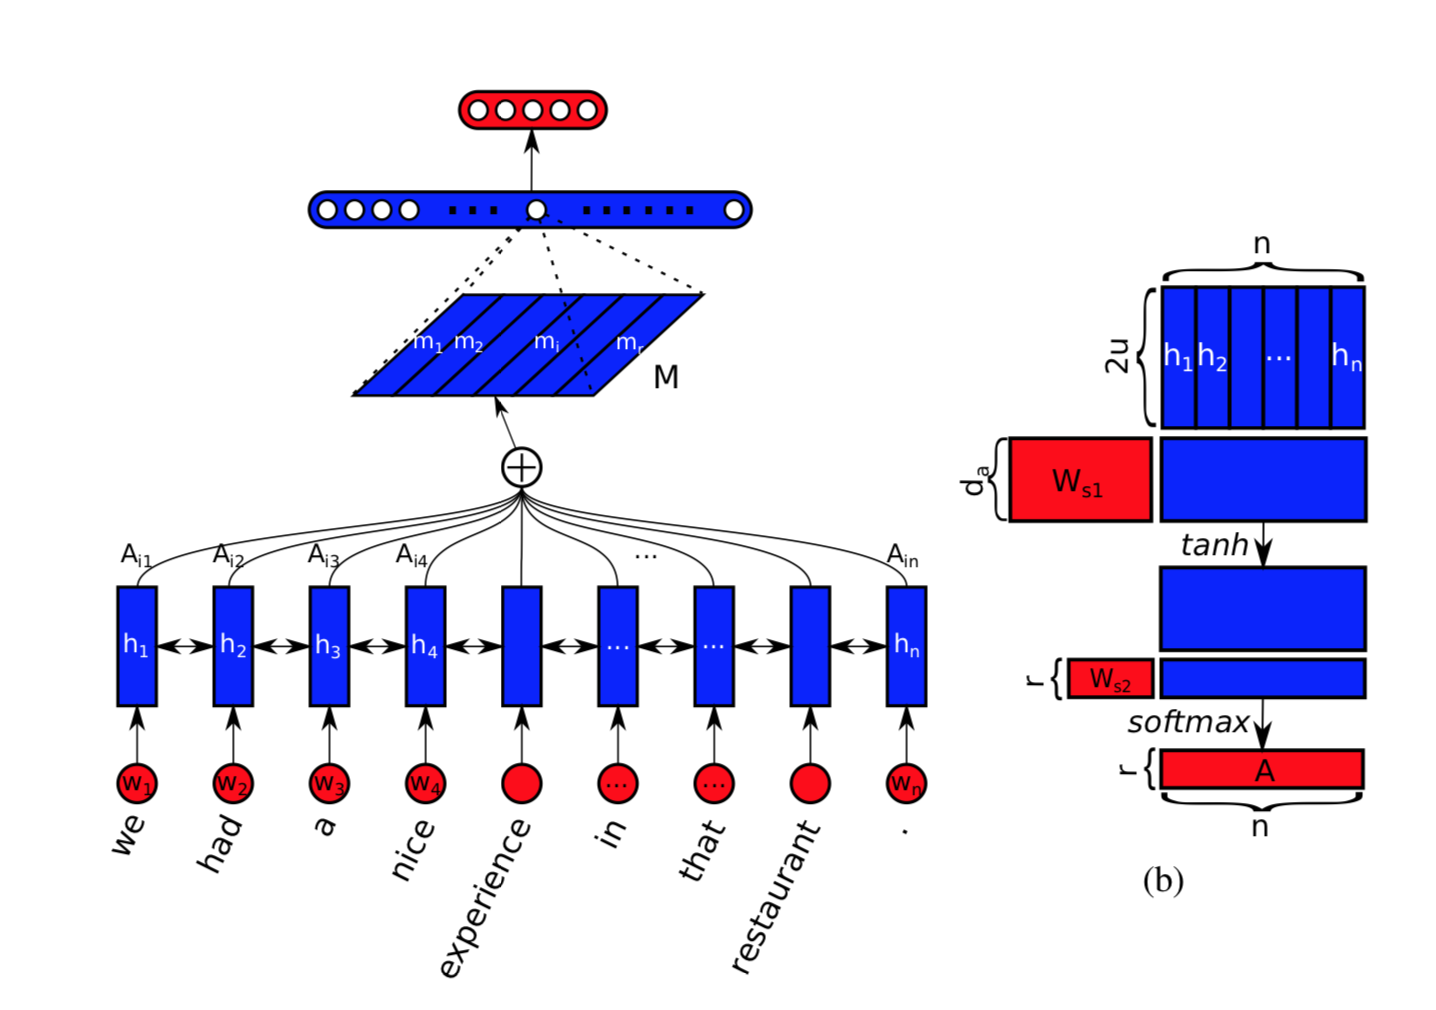

In [1]:
from IPython.display import Image, HTML, display
Image("images/model_self.png")

- Bidirectional LSTM + Self attention mechanism
- Can be used in any downstream task

Suppose, we have a sentence containing $n$ tokens : 

$$ S = (w_1, w_2, ... , w_n) $$

Using Bidirectional LSTM, we can get a set of hidden states for all words:

$$ H = (h_1, h_2, .. h_n) $$

where, $h_t = \overrightarrow{h_t} + \overleftarrow{h_t}$ of dimension $2u$, and $H$ is of dimension $n$ x $2u$

Then, an attention vector $a$ can be defined as a linear combination of states in $H$:

$$ a = softmax(w_{s_2}tanh(W_{s_1}H^T)) $$ of size $n$

where, 

- $W_{s_1}$ = $d_a$ x $2u$, where $d_a$ is a hyperparameter
- $w_{s_2}$ is a vector of size $d_a$

Finally, we get a vector representation $m$ of the sentence after summing up the hidden states of the lstm: $$m = a x H$$

The novel part is, a sentence might have multiple aspects of attention, such as multiple parts of the sentence can reflect a certain aspect. Thus to represent the overall semantics of the sentence, we would need _multi hop_ attention. 

Thus a set of $w_{s_2}$ vectors can be converted into $r$ x $d_a$ matrix, where $r$ = number of hops.

$$ A = softmax(W_{s_2}tanh(W_{s_1}H^T)) $$

Then, the embedding vector m becomes a $r$ by $2u$ embedding matrix $M$

$$ M = AH $$

### Penalization Term

In order to force the attention to look at different aspects of the sentence, a mechanism is needed to prevent the attentions from being the same and increase diversity. 

- Authors looked at KL Divergence but it didn't work well, cited that the training is very unstable due to sparse nature of the vectors
- They proposed a novel method similar to adding L2 regularization by using Frobenius norm of a matrix

$$ P = \|(AA^T - I)\|_F $$

In order to understand how the penalty works, consider the case of two vectors $a^i$ and $a^j$ in $A$. In the dot product, we are calculating the element-wise sum like this:

$$ 0 < a_{ij} = \sum_{k=1}^n a^i_k a^j_k < 1 $$

Since $a^i$ and $a^j$ are discrete probability distributions, if the sum > 0 then it means there is overlap, if 0 then there is no overlap. Identity matrix $I$ is subtracted so that the diagonals are forced to approximate to 1.

#### Visualization

Having an attention matrix thus makes it easy to visualize which aspects of the sentence were useful in classification. For the case of sentiment classification with Yelp dataset, the authors found the following attention maps.

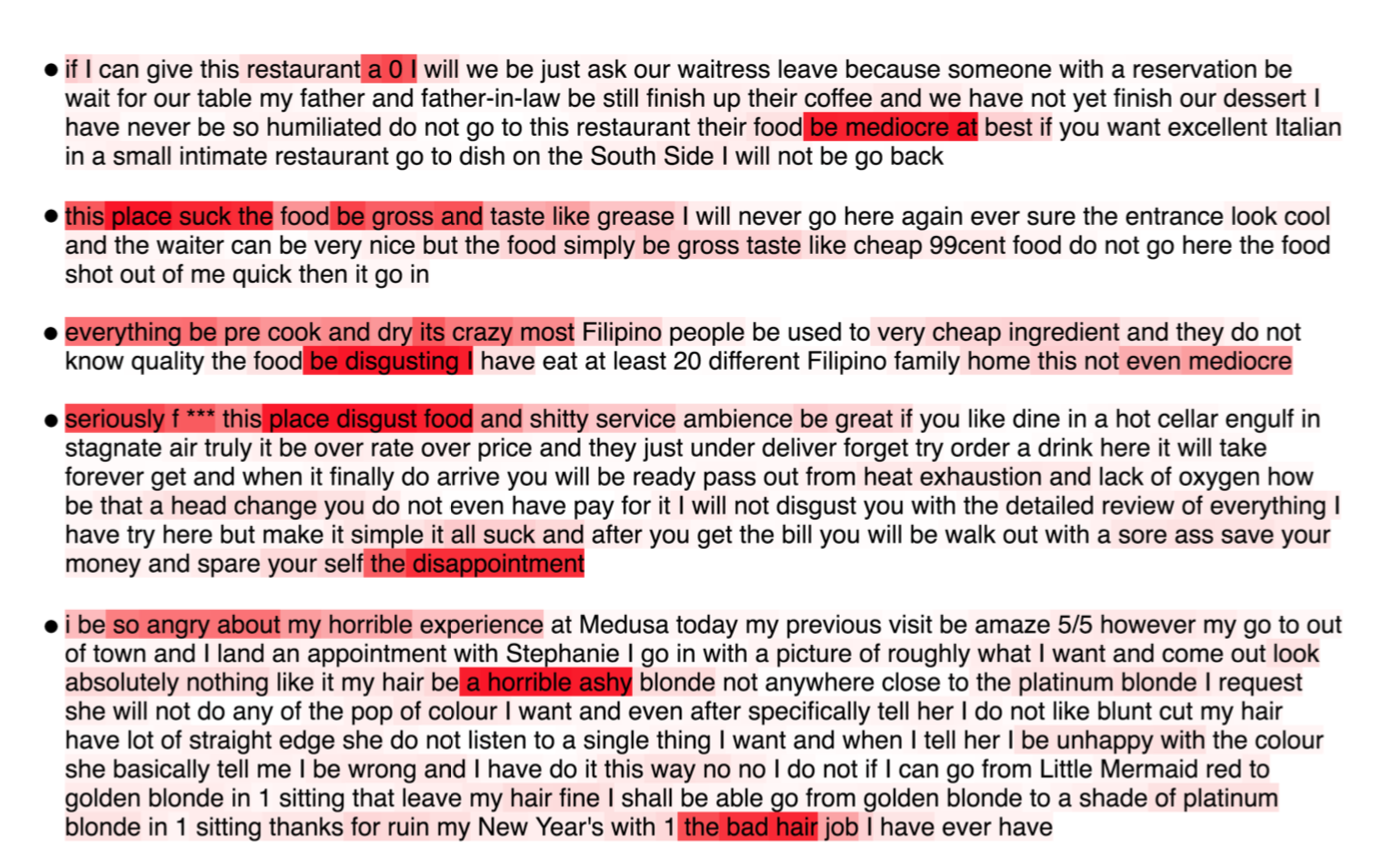

In [2]:
Image("images/one_star.png")

One star review

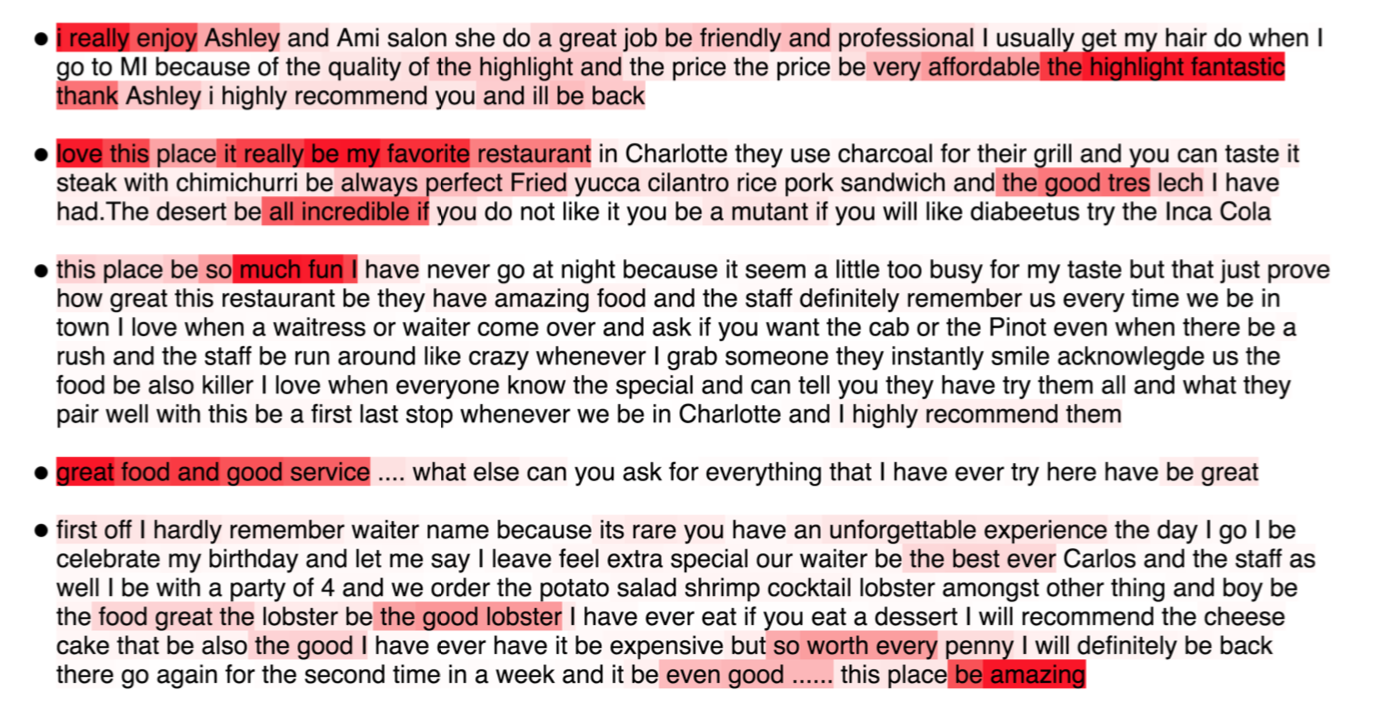

In [3]:
Image("images/five_star.png")

Five star review.

Which is very promising result. Also, the penalization has a marked effect in forcing the attention to be more diverse.

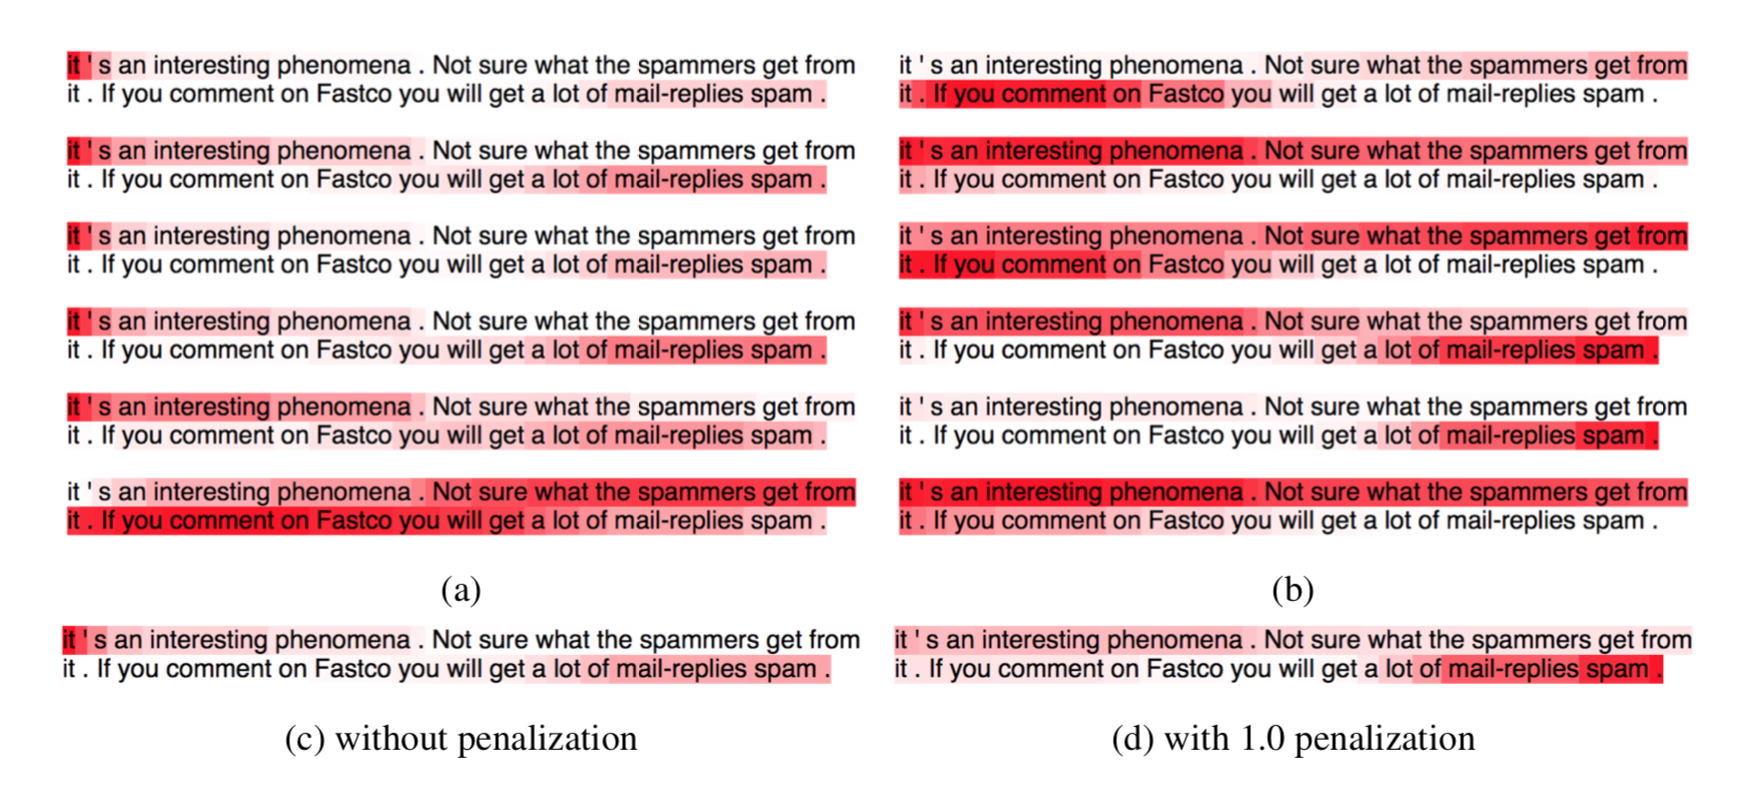

In [4]:
Image("images/penalization.png")

### Pros

- Advantage of encoding bigger sentences or even documents
- Attention picks up higher level semantics over lower level representation of LSTM
- Able to encode any sequence of variable length into a fixed set of representations

### Cons

- Heavily relies on downstream task, hence is not suitable for unsupervised training

### Paper: Attention is All You Need

Vaswani et al 2017 [Arxiv](https://arxiv.org/pdf/1706.03762.pdf)

In this paper, they have taken the similar concept of Attention for an Encoder-Decoder architecture, while totally moving away from traditional RNN based encoding and decoding.

The novel idea is to use a model termed as **Transformer**, which has stacked self-attention and point-wise fully connected layers.

- Encoder
    - 6 identical layers, where each later has two sublayers
        a. Multi-head self-attention mechanism
        b. position wise fully connected network
    - Residual connection around each of the two sublayers, followed by layer normalization (to ensure that the layers remain in reasonable range)
    
- Decoder
    - Similar architecture, but with an added layer which performs multi-head attention over the output of the encoder stack
    
In short, the paper uses the following attention tricks:

- Self Attention: Each layer combines words with others
- Multi-headed attention: 8 attention heads learned independently
- Normalized Dot-product Attention: Remove bias in dot product when using large networks
- Positional Encodings: Even if we don't have RNN, we can distinguish positions
    

#### Scaled Dot Product Attention

- Attention(Query, Key, Value) = output
    - Output = weighted sum of values.
    - Weight associated with each value = compatibility function of the query with the corresponding key

where,

- Query : decoder state
- Key, Value pair vectors : all encoder states

Given a key $k$ and query $q$, we have seen sevaral types of attention mechanisms in the past:

- Multi-layer Perceptron (Bahdanau et al) : $a(q,k) = w_2^T tanh(W_1[q:,k])$
- Bilinear (Luong et al, 2015) : $a(q,k) = q^TWk$
- Dot Product Attention (Luong et.al 2015) = $a(q,k) = q^Tk$

Problem with dot product attention is the scale of dot product increases as dimensions get larger. So, the authors fixed it with a scale:

$$ a(q,k) = \frac{q^Tk}{\sqrt(|k|)} $$

Value vectors are also encoder state, which used in Scaled Dot Product Attention is calculating:

$$ Attention(Q,K,V) = softmax(\frac{QK^T}{\sqrt(d_k)}V$$

#### Multi Head Attention

Similar to the concept in Lin et al, instead of calculating attention in single attention, the authors calculated in $h$ hops with different key value and output values. Those are concatenated to get the final matrix.

$$ MultiHead(Q,K,V) = Concat(head_1,... head_h)W^0 $$

where, $head_i = Attention(QW_i^Q, KW_i^K, VW_i^V)$

#### Applications of attention

- $Q$ from previous decoder layer, $K$ and $V$ from output of encoder = allows every position in decoder to attend over all positions of input sequence
- Each position in encoder can attend to all positions in previous layer of encoder using self attention
- Self-attention in decoder allows it to attend to all positions in decoder up to and including that position

#### Positional Encodings

Since the model contains no recurrence or convolutions, in order for the model to make use of the sequence, some information about the relative or absolute position needs to be injected. They calculate the encoding using sine and cosine functions.

$$PE(pos,2i) = sin(pos/10000^{2i/d_model})$$

$$PE(pos,2i+1) = cos(pos/10000^{2i/d_model})$$

where, $d_model$ is the dimension of the encoding.

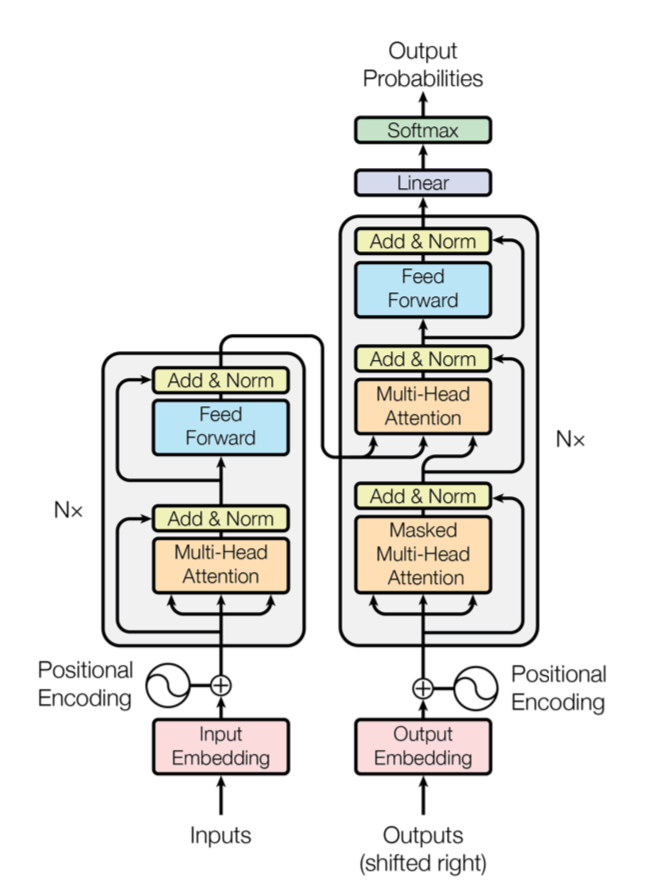

In [7]:
Image("images/transformer_model.png")

#### Benefits of Using Self Attention

- Less computation complexity
    - Faster than recurrent layers when the sequence length $n$ is smaller than representation dimensionality $d$
- Parallelizable computation
- Learning long range dependencies
- More interpretable models

## References

- "Attention is All you need" explanation material heavily borrowed from http://phontron.com/class/nn4nlp2017/assets/slides/nn4nlp-09-attention.pdf